In [7]:
import cv2
import os
import xml.etree.ElementTree as ET
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from PIL import Image
import shutil
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from imblearn.over_sampling import SMOTE

In [8]:
video_path = 'C:/Users/HP/Zoomcamp/Datasets/nakawa_output.avi'
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

fps = cap.get(cv2.CAP_PROP_FPS)

# Frame extraction rate (every 2 seconds)
extraction_rate = 2  
frame_skip = int(fps * extraction_rate)

frame_dir = 'video_frames'
os.makedirs(frame_dir, exist_ok=True)

count = 0
frame_index = 0

while True:
    ret, frame = cap.read()

    if not ret:
        break

    if frame_index % frame_skip == 0:
        frame_filename = os.path.join(frame_dir, f"frame_{count:05d}.jpg")
        cv2.imwrite(frame_filename, frame)
        count += 1
    
    frame_index += 1

cap.release()
print(f"Frames extracted: {count}")

Frames extracted: 1248


In [9]:
base_dir = 'D:/Users HP/Downloads/cnn'
images_dir = os.path.join(base_dir, 'JPEGImages')
annotations_dir = os.path.join(base_dir, 'Annotations')

data_splits = ['train', 'val', 'test']
for split in data_splits:
    os.makedirs(os.path.join(base_dir, split, 'Images'), exist_ok=True)
    os.makedirs(os.path.join(base_dir, split, 'Annotations'), exist_ok=True)

all_files = [os.path.splitext(f)[0] for f in os.listdir(images_dir) if f.endswith('.jpg') or f.endswith('.png')]

train_files, test_files = train_test_split(all_files, test_size=0.3, random_state=42)  
train_files, val_files = train_test_split(train_files, test_size=0.2, random_state=42)  

def copy_files(files, src_folder_images, src_folder_annotations, dst_folder_images, dst_folder_annotations):
    for fname in files:
        shutil.copy(os.path.join(src_folder_images, fname + '.jpg'), os.path.join(dst_folder_images, fname + '.jpg'))
        shutil.copy(os.path.join(src_folder_annotations, fname + '.xml'), os.path.join(dst_folder_annotations, fname + '.xml'))

for file_set, split in [(train_files, 'train'), (val_files, 'val'), (test_files, 'test')]:
    copy_files(file_set, images_dir, annotations_dir, os.path.join(base_dir, split, 'Images'), os.path.join(base_dir, split, 'Annotations'))

print('Dataset successfully organized and split into train, validation, and test sets.')

Dataset successfully organized and split into train, validation, and test sets.


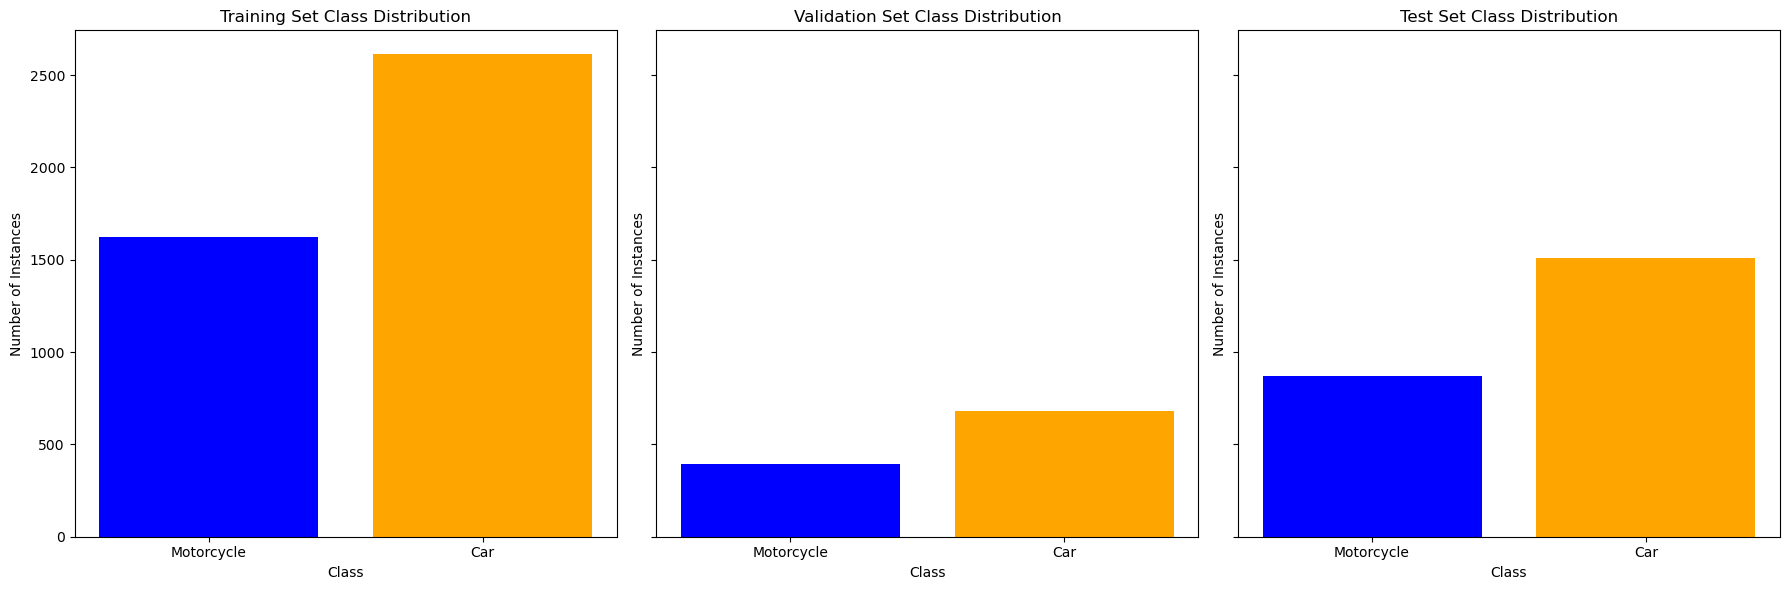

In [10]:
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

def count_classes(directory):
    class_counts = {}
    annotation_dir = os.path.join(directory, 'Annotations')
    
    for filename in os.listdir(annotation_dir):
        if filename.endswith('.xml'):
            path = os.path.join(annotation_dir, filename)
            tree = ET.parse(path)
            root = tree.getroot()
            for member in root.findall('object'):
                class_name = member.find('name').text
                if class_name in class_counts:
                    class_counts[class_name] += 1
                else:
                    class_counts[class_name] = 1
    
    return class_counts

# Path to the dataset directory
base_dir = 'D:/Users HP/Downloads/cnn'

# Counting classes in each dataset split
train_counts = count_classes(os.path.join(base_dir, 'train'))
val_counts = count_classes(os.path.join(base_dir, 'val'))
test_counts = count_classes(os.path.join(base_dir, 'test'))

# Plotting the class distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

def plot_distribution(ax, counts, title):
    ax.bar(counts.keys(), counts.values(), color=['blue', 'orange'])
    ax.set_title(title)
    ax.set_ylabel('Number of Instances')
    ax.set_xlabel('Class')

plot_distribution(axes[0], train_counts, 'Training Set Class Distribution')
plot_distribution(axes[1], val_counts, 'Validation Set Class Distribution')
plot_distribution(axes[2], test_counts, 'Test Set Class Distribution')

plt.tight_layout()
plt.show()

C:\Users\HP\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 238, 318, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 119, 159, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 117, 157, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 58, 78, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 76, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 38, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 136192)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      69,730,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,824,577 (266.36 MB)

 Trainable params: 69,824,577 (266.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


C:\Users\HP\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


164/164 ━━━━━━━━━━━━━━━━━━━━ 395s 2s/step - accuracy: 0.5236 - loss: 43.1458 - val_accuracy: 0.6187 - val_loss: 0.6789 - learning_rate: 1.0000e-04
Epoch 2/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 434s 3s/step - accuracy: 0.6407 - loss: 0.6229 - val_accuracy: 0.3701 - val_loss: 0.9696 - learning_rate: 1.0000e-04
Epoch 3/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 359s 2s/step - accuracy: 0.6710 - loss: 0.5970 - val_accuracy: 0.3673 - val_loss: 1.3511 - learning_rate: 1.0000e-04
Epoch 4/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 358s 2s/step - accuracy: 0.6946 - loss: 0.5744 - val_accuracy: 0.3673 - val_loss: 3.0175 - learning_rate: 1.0000e-04
Epoch 5/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 351s 2s/step - accuracy: 0.6981 - loss: 0.5696 - val_accuracy: 0.3673 - val_loss: 3.4079 - learning_rate: 1.0000e-04
Epoch 6/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 349s 2s/step - accuracy: 0.6903 - loss: 0.5643 - val_accuracy: 0.3673 - val_loss: 4.3935 - learning_rate: 1.0000e-04
Epoch 7/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 352s 2s/step - accuracy: 0.7

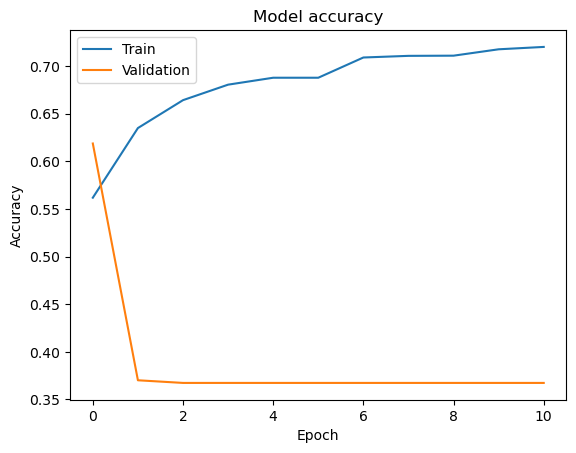

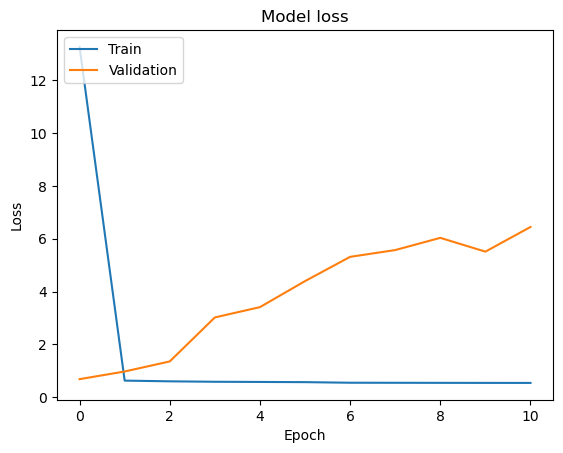

In [1]:
import numpy as np
import cv2
import os
import xml.etree.ElementTree as ET
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Function to load images and labels
def load_images_and_labels(image_dir, annot_dir):
    images = []
    labels = []
    for annot_file in os.listdir(annot_dir):
        if annot_file.endswith('.xml'):
            annot_path = os.path.join(annot_dir, annot_file)
            tree = ET.parse(annot_path)
            root = tree.getroot()
            filename = root.find('filename').text
            image_path = os.path.join(image_dir, filename)
            image = cv2.imread(image_path)
            if image is not None:  
                image = cv2.resize(image, (240, 320))  
                for obj in root.findall('object'):
                    label = obj.find('name').text
                    if label == 'Car':
                        labels.append(0)
                    elif label == 'Motorcycle':
                        labels.append(1)
                    images.append(image)
            else:
                print(f"Warning: Failed to load image {image_path}")
    return np.array(images), np.array(labels)

# Loading datasets
base_dir = 'D:/Users HP/Downloads/cnn'
train_image_dir = os.path.join(base_dir, 'train', 'Images')
train_annot_dir = os.path.join(base_dir, 'train', 'Annotations')
val_image_dir = os.path.join(base_dir, 'val', 'Images')
val_annot_dir = os.path.join(base_dir, 'val', 'Annotations')
test_image_dir = os.path.join(base_dir, 'test', 'Images')
test_annot_dir = os.path.join(base_dir, 'test', 'Annotations')

X_train, y_train = load_images_and_labels(train_image_dir, train_annot_dir)
X_val, y_val = load_images_and_labels(val_image_dir, val_annot_dir)
X_test, y_test = load_images_and_labels(test_image_dir, test_annot_dir)

# Reshaping data to 2D array for SMOTE
X_train_reshaped = X_train.reshape((X_train.shape[0], -1))

# Applying SMote to the training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_reshaped, y_train)

# Reshaping data back to original shape
X_train_balanced = X_train_balanced.reshape((X_train_balanced.shape[0], 240, 320, 3))

# Creating Data Generators
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train_balanced, y_train_balanced, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32)

# Building a Basic CNN Model
def build_basic_cnn_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

input_shape = (240, 320, 3)
cnn_model = build_basic_cnn_model(input_shape)
cnn_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Training the model
history = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluating the model
def evaluate_model(model, test_generator):
    predictions = model.predict(test_generator)
    y_true = np.concatenate([test_generator[i][1] for i in range(len(test_generator))])
    y_pred = (predictions > 0.5).astype(int).reshape(-1)
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred, target_names=['Car', 'Motorcycle'])
    return cm, cr

cm, cr = evaluate_model(cnn_model, test_generator)

print("Confusion Matrix:\n", cm)
print("Classification Report:\n", cr)

# Plotting the training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Ploting the training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


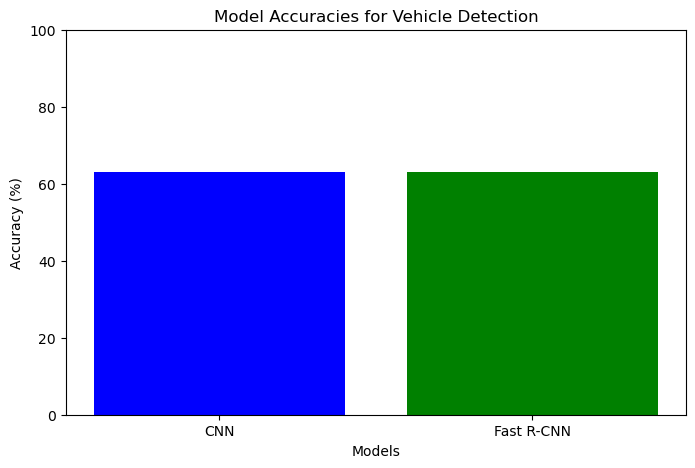

In [1]:
import matplotlib.pyplot as plt

# Model accuracies
models = ['CNN', 'Fast R-CNN']
accuracies = [63, 63]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['blue', 'green'])
plt.ylim(0, 100)
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracies for Vehicle Detection')
plt.show()